Converged at iteration 5
Top 10 lines
#1: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/IPython/core/compilerop.py:86: 303.6 KiB
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
#2: /opt/miniconda3/envs/pyenv/lib/python3.11/ast.py:50: 300.8 KiB
    return compile(source, filename, mode, flags,
#3: <string>:1: 181.6 KiB
#4: /opt/miniconda3/envs/pyenv/lib/python3.11/tokenize.py:532: 168.8 KiB
    spos, epos, pos = (lnum, start), (lnum, end), end
#5: /var/folders/hr/6z6ktnc54sq3znbt3300vqnh0000gp/T/ipykernel_94673/1367908797.py:39: 156.3 KiB
    vr = vr / np.linalg.norm(vr, axis=0)  # Right eigenvectors
#6: /var/folders/hr/6z6ktnc54sq3znbt3300vqnh0000gp/T/ipykernel_94673/1367908797.py:38: 156.3 KiB
    vl = vl / np.linalg.norm(vl, axis=0)  # Left eigenvectors
#7: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/asttokens/line_numbers.py:60: 93.1 KiB
    return min(self._line_offsets[line] + max(0, column), self._text_len)
#8: /var/folders/hr/6z6

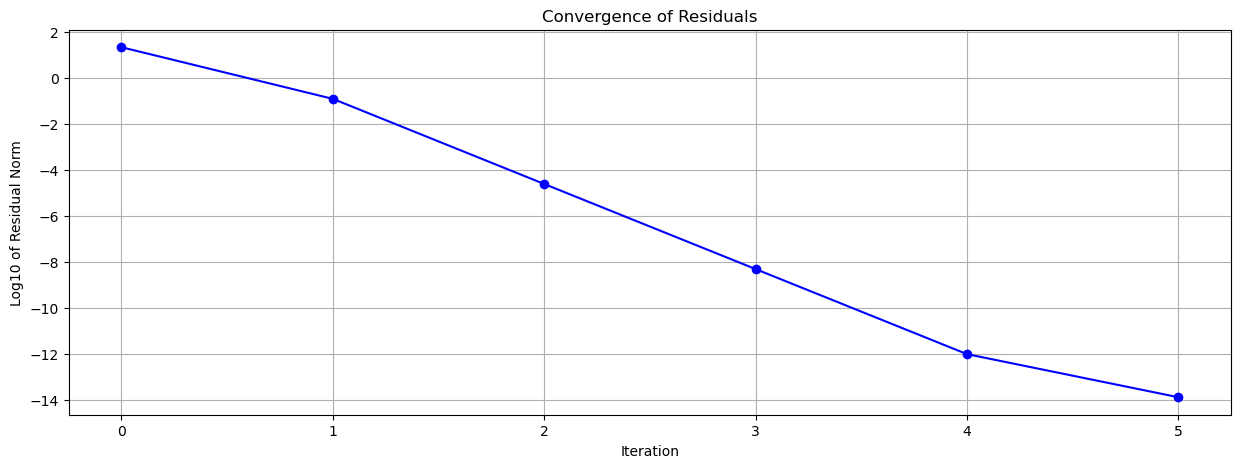

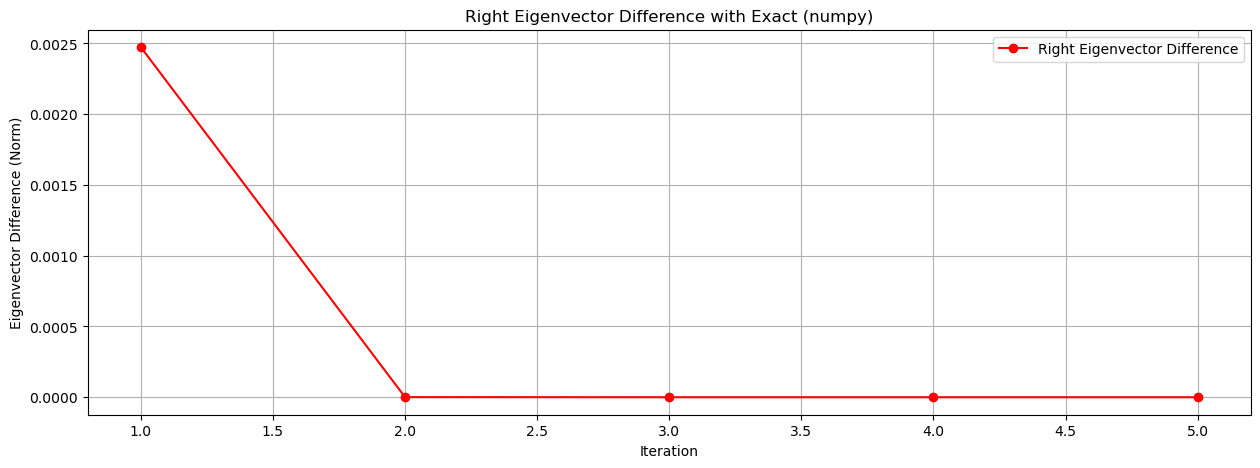

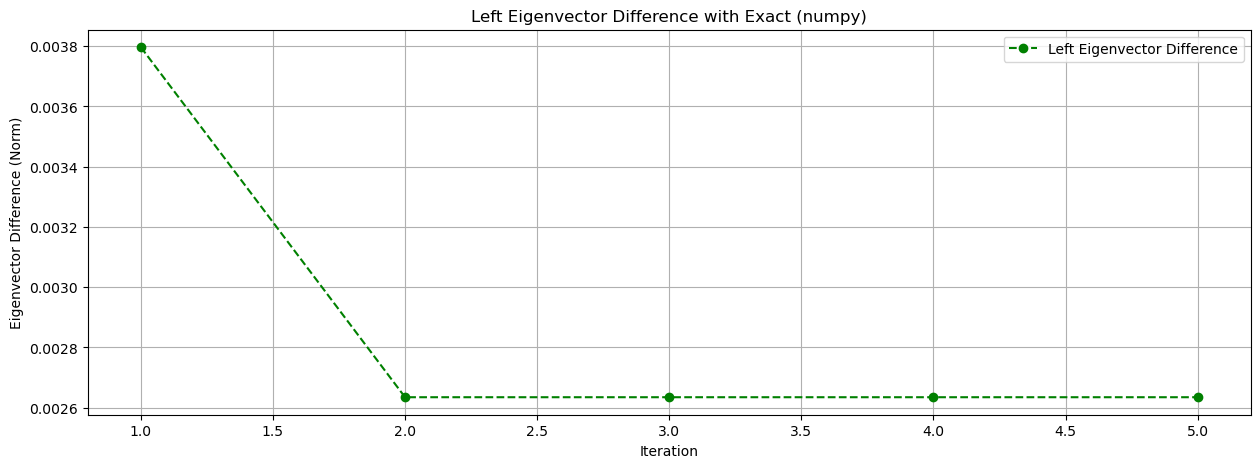

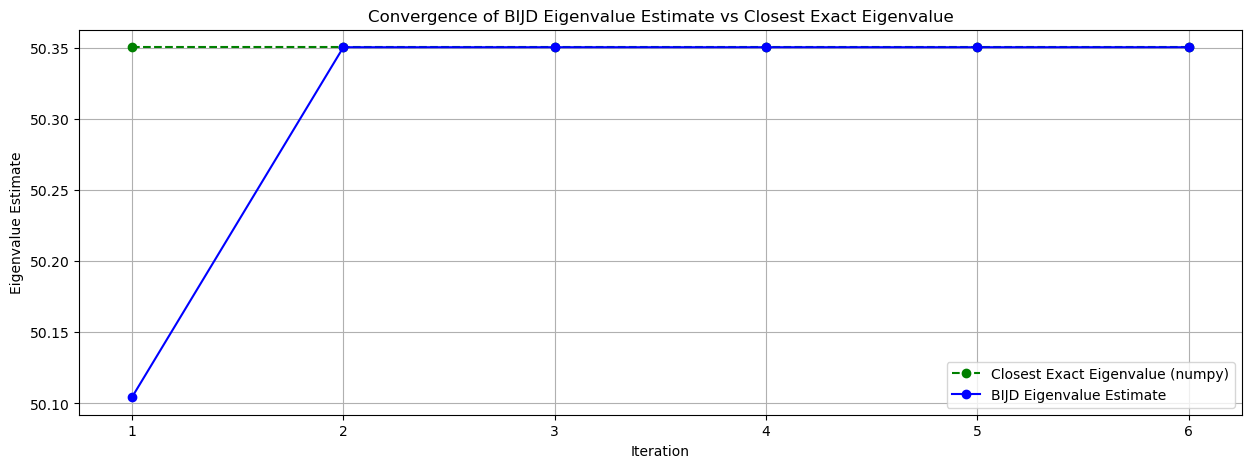

Eigenvalue (BIJD): 50.350512608303546
0.010043999999993503


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, eig
import time
import tracemalloc
import linecache

def bi_orthogonal_jacobi_davidson(A, vR_init, vL_init, tol=1e-13, max_iter=800, shift=1e-15, reg=1e-2):
    """
    Bi-Orthogonal Jacobi-Davidson method with regularization and shift-invert for non-Hermitian eigenvalue problems.
    Tracks residual norms and eigenvalue approximations for comparison against the exact solution.
    
    Args:
        A (ndarray): The input non-Hermitian matrix.
        vR_init (ndarray): Initial guess for the right eigenvector.
        vL_init (ndarray): Initial guess for the left eigenvector.
        tol (float): Convergence tolerance for residuals.
        max_iter (int): Maximum number of iterations.
        shift (float): Shift-invert value to avoid singularity.
        reg (float): Regularization term to stabilize matrix inversion.

    Returns:
        tuple: Eigenvalue, corresponding left and right eigenvectors, residuals history, BIJD eigenvalue estimates, and eigenvector comparisons.
    """
    # Initialize right and left eigenvectors
    vR = vR_init / np.linalg.norm(vR_init)
    vL = vL_init / np.linalg.norm(vL_init)
    
    residuals = []  # List to store the norm of the residuals
    bijd_eigenvalue_estimates = []  # List to store the BIJD eigenvalue estimates
    vR_diffs = []  # List to store the right eigenvector differences
    vL_diffs = []  # List to store the left eigenvector differences
    
    # Get the exact eigenvalues and eigenvectors using scipy.linalg.eig
    w, vl, vr = eig(A, left=True)
    
    # Normalize the left eigenvectors (vl) and right eigenvectors (vr)
    vl = vl / np.linalg.norm(vl, axis=0)  # Left eigenvectors
    vr = vr / np.linalg.norm(vr, axis=0)  # Right eigenvectors
    
    for i in range(max_iter):
        # Compute the dot product for bi-orthogonality
        dot_product = np.dot(vL.conj().T, vR)
        
        # Avoid division by zero
        if np.abs(dot_product) < tol:
            print(f"Warning: Re-initializing left vector at iteration {i} due to orthogonality issues.")
            vL = np.random.rand(*vL.shape)
            vL = vL / np.linalg.norm(vL)
            continue
        
        # Ensure bi-orthogonality: vL^H * vR = 1
        vL = vL / dot_product
        
        # Compute the Rayleigh quotient (estimate for the eigenvalue)
        lambda_est = np.dot(vL.conj().T, A @ vR)
        
        # Store BIJD eigenvalue estimate for plotting
        bijd_eigenvalue_estimates.append(lambda_est)
        
        # Compute residuals
        rR = (A @ vR) - lambda_est * vR
        rL = (A.conj().T @ vL) - lambda_est.conj() * vL
        
        # Track the residual norm for convergence plot
        residual_norm = np.linalg.norm(rR)
        residuals.append(residual_norm)
        
        # Check for convergence
        if residual_norm < tol and np.linalg.norm(rL) < tol:
            print(f"Converged at iteration {i}")
            break
        
        # Solve correction equations for right and left eigenvectors with shift and regularization
        M_R = A - lambda_est * np.eye(A.shape[0]) + shift * np.eye(A.shape[0])
        M_L = A.conj().T - lambda_est.conj() * np.eye(A.shape[0]) + shift * np.eye(A.shape[0])
        
        # Apply orthogonal projection to the correction equations
        M_R_proj = M_R - np.outer(vR, vR.conj().T @ M_R)
        M_L_proj = M_L - np.outer(vL, vL.conj().T @ M_L)
        
        # Add regularization to prevent singularity
        M_R_proj += reg * np.eye(M_R_proj.shape[0])
        M_L_proj += reg * np.eye(M_L_proj.shape[0])
        
        # Solve the linear systems for the corrections
        try:
            delta_R = solve(M_R_proj, -rR)
            delta_L = solve(M_L_proj, -rL)
        except ValueError as e:
            print(f"Error solving correction equation at iteration {i}: {e}")
            break
        
        # Update the right and left eigenvectors
        vR += delta_R
        vL += delta_L
        
        # Normalize and re-orthogonalize
        vR = vR / np.linalg.norm(vR)
        vL = vL / np.dot(vL.conj().T, vR)
        
        # Compare right eigenvector
        vR_closest = vr[:, np.argmin(np.abs(w - lambda_est))]
        vR_diff = np.linalg.norm(np.abs(vR) - np.abs(vR_closest))
        vR_diffs.append(vR_diff)
        
        # Compare left eigenvector
        vL_closest = vl[:, np.argmin(np.abs(w - lambda_est))]
        vL_diff = np.linalg.norm(np.abs(vL) - np.abs(vL_closest))
        vL_diffs.append(vL_diff)
    
    return lambda_est, vR, vL, residuals, bijd_eigenvalue_estimates, vR_diffs, vL_diffs, w, vl, vr


# Example usage
n = 100  # Change this to adjust matrix size
A = np.random.rand(n, n)   # Generate a random complex matrix
#A = A + A.T  # Make it Hermitian by adding its transpose
vR_init = np.random.rand(n)   # Random initial guess for right eigenvector
vL_init = np.random.rand(n)  # Random initial guess for left eigenvector

# Run the BIJD algorithm
def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

tracemalloc.start()
t0 = time.process_time()
eigenvalue, vR, vL, residuals, bijd_eigenvalue_estimates, vR_diffs, vL_diffs, exact_eigenvalues, exact_left_eigenvectors, exact_right_eigenvectors = bi_orthogonal_jacobi_davidson(A, vR_init, vL_init)
t1 = time.process_time()
snapshot = tracemalloc.take_snapshot()
display_top(snapshot)
print(tracemalloc.get_traced_memory())

# stopping the library
tracemalloc.stop()
# Plotting the eigenvector differences
iterations = np.arange(1, len(vR_diffs) + 1)

# Plotting the residual norm versus iteration
plt.figure(figsize=(15, 5))

plt.subplot()
plt.plot(np.log10(residuals), marker='o', linestyle='-', color='b')
plt.title("Convergence of Residuals")
plt.xlabel("Iteration")
plt.ylabel("Log10 of Residual Norm")
plt.grid(True)
plt.show()

# Plot the right eigenvector difference
plt.figure(figsize=(15, 5))
plt.plot(iterations, vR_diffs, marker='o', linestyle='-', color='red', label='Right Eigenvector Difference')
plt.title("Right Eigenvector Difference with Exact (numpy)")
plt.xlabel("Iteration")
plt.ylabel("Eigenvector Difference (Norm)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the left eigenvector difference
plt.figure(figsize=(15, 5))
plt.plot(iterations, vL_diffs, marker='o', linestyle='--', color='green', label='Left Eigenvector Difference')
plt.title("Left Eigenvector Difference with Exact (numpy)")
plt.xlabel("Iteration")
plt.ylabel("Eigenvector Difference (Norm)")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the eigenvalue estimates vs exact eigenvalue
iterations = np.arange(1, len(bijd_eigenvalue_estimates) + 1)

# Find the closest numpy.eig eigenvalue at each iteration for comparison
closest_exact_values = []
for estimate in bijd_eigenvalue_estimates:
    closest_exact_values.append(exact_eigenvalues[np.argmin(np.abs(exact_eigenvalues - estimate))])

# Plot the closest exact eigenvalue at each iteration
plt.figure(figsize=(15, 5))
plt.plot(iterations, closest_exact_values, marker='o',label='Closest Exact Eigenvalue (numpy)', linestyle='--', color='green')
plt.plot(iterations, bijd_eigenvalue_estimates,marker='o',  linestyle='-', color='blue', label='BIJD Eigenvalue Estimate')
plt.title("Convergence of BIJD Eigenvalue Estimate vs Closest Exact Eigenvalue")
plt.xlabel("Iteration")
plt.ylabel("Eigenvalue Estimate")
plt.legend()
plt.grid(True)
plt.show()

print("Eigenvalue (BIJD):", eigenvalue)
print(t1-t0)


In [48]:
closest_exact_values

[(100.9608511989706+0j),
 (100.9608511989706+0j),
 (100.9608511989706+0j),
 (100.9608511989706+0j),
 (100.9608511989706+0j),
 (100.9608511989706+0j)]

In [49]:
np.linalg.eig(A)[0][0]

100.9608511989706

Converged in 58 iterations.
Eigenvalues: [-5.80601292]
Time elapsed: 0.2560749999999956 seconds
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


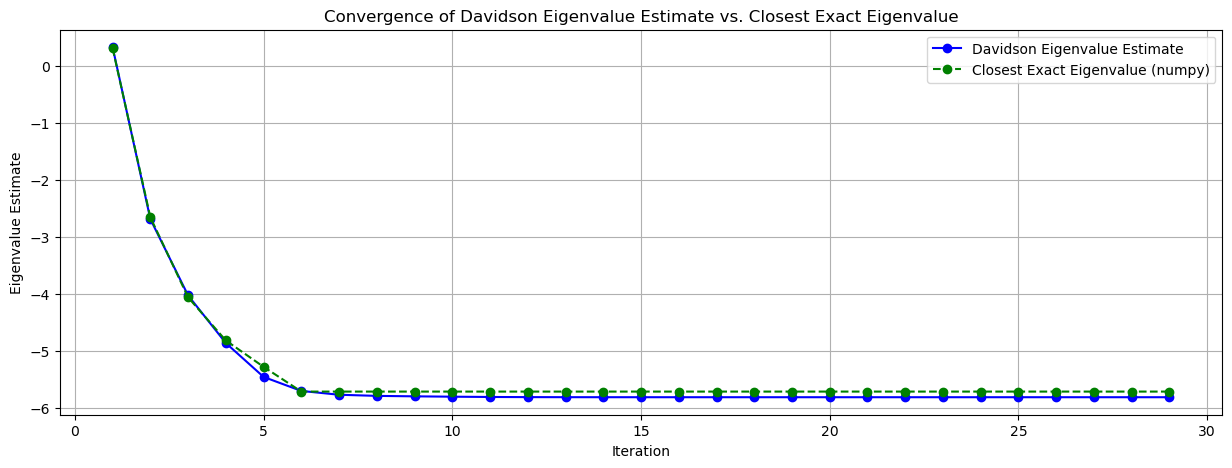

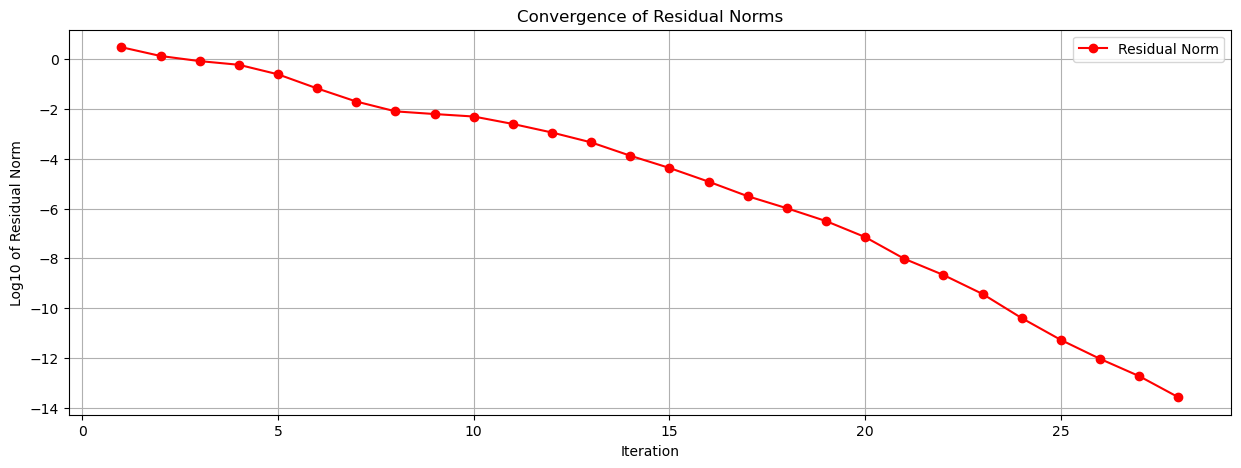

Top 10 lines
#1: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/matplotlib/lines.py:359: 194.9 KiB
    self._solidcapstyle = None
#2: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/matplotlib/text.py:994: 153.1 KiB
    self._color = color
#3: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/matplotlib/transforms.py:198: 101.5 KiB
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
#4: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/matplotlib/cbook.py:188: 66.7 KiB
    self._pickled_cids = set()
#5: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/matplotlib/axis.py:120: 61.8 KiB
    self._width = width
#6: /opt/miniconda3/envs/pyenv/lib/python3.11/copyreg.py:105: 55.7 KiB
    return cls.__new__(cls, *args)
#7: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/matplotlib/transforms.py:199: 52.8 KiB
    child._parents[id_self] = ref
#8: /opt/miniconda3/envs/pyenv/lib/python3.11/site-packages/jupyter_client/session.py:100: 48.4 KiB

(1.7382917124108885+2.4097691540620283j)

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import time

def davidson_2(A, k=None, n_eigen=1, tol=1e-13, maxiter=100):
    """
    Block Davidson method for finding the first few lowest eigenvalues of a large, diagonally dominant,
    sparse Hermitian matrix (e.g., Hamiltonian).
    
    Args:
        A (ndarray): Hermitian matrix.
        k (int): Dimension of trial subspace, typically a few times the number of desired eigenvalues.
        n_eigen (int): Number of lowest eigenvalues to find.
        tol (float): Convergence tolerance for residual norms.
        maxiter (int): Maximum number of iterations.
    
    Returns:
        tuple: (Eigenvalues, eigenvectors, residuals history, eigenvalue estimates history)
    """
    n = A.shape[0]
    if maxiter is None:
        maxiter = n // 2   # set a default maxiter based on matrix size

    if k is None:
        k = 2 * n_eigen  # default trial subspace dimension
    t = np.eye(n, k)  # initial set of k unit vectors
    V = np.zeros((n, n))  # store orthogonalized vectors
    I = np.eye(n)
    residuals = []
    eigenvalue_estimates = []

    # Compute exact eigenvalues for comparison
    exact_eigenvalues, _ = np.linalg.eigh(A)
    exact_eigenvalues = np.sort(exact_eigenvalues)  # Sort for closest comparison

    start_time = time.process_time()

    # Begin Block Davidson routine
    for iter_count in range(k, maxiter, k):
        if iter_count <= k:
            # Orthogonalize initial guess vectors
            for j in range(k):
                V[:, j] = t[:, j] / np.linalg.norm(t[:, j])
            theta_old = np.inf
        else:
            theta_old = theta[:n_eigen]
        
        # Orthogonalize V
        V[:, :iter_count], _ = np.linalg.qr(V[:, :iter_count])
        
        # Project matrix A onto the subspace
        T = V[:, :iter_count].T @ A @ V[:, :iter_count]
        THETA, S = np.linalg.eigh(T)
        idx = THETA.argsort()
        theta = THETA[idx]
        s = S[:, idx]
        
        # Save the closest exact eigenvalue to the estimated eigenvalue for plotting
        closest_exact_value = exact_eigenvalues[np.argmin(np.abs(exact_eigenvalues - theta[0]))]
        eigenvalue_estimates.append((theta[0], closest_exact_value))

        # Correction step
        for j in range(k):
            # Compute correction vector
            w = (A - theta[j] * I) @ (V[:, :iter_count] @ s[:, j])
            q = w / (theta[j] - A[j, j])
            V[:, iter_count + j] = q
        
        # Check for convergence
        norm = np.linalg.norm(theta[:n_eigen] - theta_old)
        residuals.append(norm)
        if norm < tol:
            print(f"Converged in {iter_count} iterations.")
            break

    end_time = time.process_time()

    print(f"Eigenvalues: {theta[:n_eigen]}")
    print(f"Time elapsed: {end_time - start_time} seconds")

    # Plot convergence of eigenvalue estimates versus closest exact eigenvalue
    eigenvalues_davidson, closest_exact_values = zip(*eigenvalue_estimates)
    iterations = np.arange(1, len(eigenvalues_davidson) + 1)

    print(iterations)
    plt.figure(figsize=(15, 5))
    plt.plot(iterations, eigenvalues_davidson, 'bo-', label="Davidson Eigenvalue Estimate")
    plt.plot(iterations, closest_exact_values, 'go--', label="Closest Exact Eigenvalue (numpy)")
    plt.title("Convergence of Davidson Eigenvalue Estimate vs. Closest Exact Eigenvalue")
    plt.xlabel("Iteration")
    plt.ylabel("Eigenvalue Estimate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot residuals convergence
    plt.figure(figsize=(15, 5))
    plt.plot(np.log10(residuals), 'ro-', label="Residual Norm")
    plt.title("Convergence of Residual Norms")
    plt.xlabel("Iteration")
    plt.ylabel("Log10 of Residual Norm")
    plt.legend()
    plt.grid(True)
    plt.show()

    return theta[:n_eigen], s[:, :n_eigen], residuals, eigenvalue_estimates

# Example usage:
n = 100  # Size of matrix
#A = np.random.rand(n, n)

#A = A + A.T  # Make A symmetric to ensure it's Hermitian

# Find the first eigenvalue and compare
def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))
tracemalloc.start()
t0 = time.process_time()
eigenvalues, eigenvectors, residuals, eigenvalue_estimates = davidson_2(A, n_eigen=1)
t1 = time.process_time()
snapshot = tracemalloc.take_snapshot()
display_top(snapshot)
print(tracemalloc.get_traced_memory())

# stopping the library
tracemalloc.stop()
print(t1-t0)
np.linalg.eig(A)[0][1]

In [69]:
eigenvalue_estimates

[(-0.030134736292319553, 0.02444278861085902),
 (-2.597075084073607, -2.628798715071414),
 (-3.662648599069741, -3.680668979264925),
 (-4.46064810771032, -4.355978499225801),
 (-4.771767604862047, -4.8364395701824145),
 (-4.916194897836198, -4.8364395701824145),
 (-5.039338210166834, -5.122230188531725),
 (-5.302804328822398, -5.2517996453963915),
 (-5.458629354297367, -5.568637752593677),
 (-5.536980677389598, -5.568637752593677),
 (-5.5718042892569075, -5.568637752593677),
 (-5.582949041623164, -5.568637752593677),
 (-5.586174970093072, -5.568637752593677),
 (-5.587564758690047, -5.568637752593677),
 (-5.588299752827068, -5.568637752593677),
 (-5.588664164986301, -5.568637752593677),
 (-5.588797204168962, -5.568637752593677),
 (-5.588840336852308, -5.568637752593677),
 (-5.588857191195502, -5.568637752593677),
 (-5.588862790221113, -5.568637752593677),
 (-5.588864791787902, -5.568637752593677),
 (-5.5888658681718555, -5.568637752593677),
 (-5.588866147614876, -5.568637752593677),
 (-

In [67]:
iterations

array([1, 2, 3, 4, 5, 6])